# Steam Game Popularity Predictor (MLZoomCamp 2025)

Inspired by Hu et al. (2024) paper on Steam popularity: Predict if a game gets >90% positive reviews using pre-release metadata (price, platforms, genres, etc.).

**Goal**: Train RF/XGBoost on ~89k games (SMOTE-balanced for High class ~27%). Address imbalance and biases (e.g., price penalties on franchises, legacy F2P underprediction). Deploy to API/UI. Updated AUC: 0.743 (v1.3 with IP/F2P synergies).

## Setup
Run `pip install -r requirements.txt` (add `imbalanced-learn` for SMOTE, `requests` for validation).

In [1]:
# Load & Initial EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
# For Jupyter plots
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import ast
import pickle

# Load data
df = pd.read_csv('archive/games_march2025_cleaned.csv')
print(f"Loaded shape: {df.shape}")
print("Columns:", df.columns.tolist())

# Compute positive_ratio early for EDA (before any drops)
if 'positive' in df.columns and 'negative' in df.columns:
    total_reviews = df['positive'] + df['negative']
    df['positive_ratio'] = df['positive'] / total_reviews.replace(0, np.nan)
    df['positive_ratio'] = df['positive_ratio'].fillna(0)
    df['positive'] = (df['positive_ratio'] > 0.9).astype(int)
    print("Computed positive_ratio & binary positive early for EDA (mean ratio ~0.82).")
else:
    print("Warning: positive/negative missing—skipping ratio (check data).")

print("\nImbalance: High popularity ratio =", df['positive'].mean())  # Quick check (~0.27)

# First few rows (includes ratio)
print("\nFirst few rows:")
print(df[['name', 'price', 'positive_ratio', 'positive']].head())

Loaded shape: (89618, 47)
Columns: ['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'detailed_description', 'about_the_game', 'short_description', 'reviews', 'header_image', 'website', 'support_url', 'support_email', 'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url', 'achievements', 'recommendations', 'notes', 'supported_languages', 'full_audio_languages', 'packages', 'developers', 'publishers', 'categories', 'genres', 'screenshots', 'movies', 'user_score', 'score_rank', 'positive', 'negative', 'estimated_owners', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent']
Computed positive_ratio & binary positive early for EDA (mean ratio ~0.82).

Imbalance: High popularity ratio = 0.2673123702827557

First few rows:
                              name  price  positive_ratio  positive
0        

In [2]:
# Leak Drops
# Drop low-importance: required_age
if 'required_age' in df.columns:
    df = df.drop('required_age', axis=1)
    print("Dropped required_age (low impact).")

# CRITICAL FIX: Drop leaks post-engineering (from notebook logic)
leak_cols = ['negative', 'appid', 'name', 'recommendations', 'notes', 'estimated_owners', 
             'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks',
             'peak_ccu', 'discount', 'metacritic_score', 'metacritic_url', 'score_rank']  # Post-release or ID leaks (positive_ratio dropped in Cell 5)
df = df.drop(columns=[col for col in leak_cols if col in df.columns])
print(f"Dropped leaks: {len([col for col in leak_cols if col in df.columns])} columns (e.g., negative, appid)")

Dropped required_age (low impact).
Dropped leaks: 0 columns (e.g., negative, appid)


In [3]:
# Core features
if 'genres' in df.columns:
    df['genre_count'] = df['genres'].str.split(',').str.len().fillna(1)
    print("Added genre_count (neutral variety proxy—no dummies to avoid bias).")
else:
    df['genre_count'] = 1
    print("Default genre_count=1.")

# Add supported_languages and developers_count if available (parse from data)
if 'languages' in df.columns or 'supported_languages' in df.columns:
    lang_col = 'languages' if 'languages' in df.columns else 'supported_languages'
    # FIX: Parse string list safely (e.g., "['English', 'French']" -> len=2)
    def parse_lang_count(s):
        try:
            # Strip brackets/quotes, split on ', '
            cleaned = str(s).strip("[]'").replace("'", "").split(", ")
            return len(cleaned)
        except:
            return 1  # Fallback
    df['supported_languages'] = df[lang_col].apply(parse_lang_count).fillna(1)
    print("Added supported_languages count (broader reach proxy; parsed lists).")
elif 'supported_languages' in df.columns:
    df['supported_languages'] = pd.to_numeric(df['supported_languages'], errors='coerce').fillna(1)
    print("Used existing supported_languages column.")

if 'developers' in df.columns:
    df['developers_count'] = df['developers'].astype(str).str.split(',').str.len().fillna(1)
    print("Added developers_count (indie/team size proxy).")
else:
    df['developers_count'] = 1
    print("Default developers_count=1 (indie assumption).")

# Engineer platforms_count (sum win/mac/linux if present)
if all(col in df.columns for col in ['win', 'mac', 'linux']):
    df['platforms_count'] = df[['win', 'mac', 'linux']].sum(axis=1)
    print("Engineered platforms_count.")
else:
    df['platforms_count'] = 1  # Default Windows
    print("Default platforms_count=1.")

# Add tag_count if strings
if 'tags' in df.columns:
    df['tag_count'] = df['tags'].str.split(',').str.len().fillna(1)
    print("Added tag_count.")

# Release year from date
if 'release_date' in df.columns:
    df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(2025)
    df['release_year'] = np.minimum(df['release_year'], 2025)
    print("Added/capped release_year.")

# IP & Price Interactions (from live tests: CS2 F2P-IP, SpongeBob price-IP)
if 'publishers' in df.columns:
    df['big_ip'] = df['publishers'].str.contains('Nickelodeon|THQ|Paramount|EA|Ubisoft|Valve', case=False, na=False).astype(int)
    print("Added big_ip (franchise boost).")
else:
    df['big_ip'] = 0

df['price_tier'] = pd.cut(df['price'], bins=[0, 5, 15, 30, np.inf], labels=[0,1,2,3]).cat.codes
df['price_ip_adjust'] = df['price_tier'] * (1 - df['big_ip'] * 0.5)  # Halve penalty for IP
print("Added price_ip_adjust (IP discounts high prices).")

df['f2p_ip_boost'] = ((df['price'] == 0) & (df['big_ip'] == 1)).astype(int)  # bumps for free franchises
print("Added f2p_ip_boost (F2P + IP extra).")

# Impute achievements (discovery: unreleased/low hurts; median High ~25)
df['achievements'] = df['achievements'].fillna(25).clip(upper=100)
print("Imputed/capped achievements.")

print("New features added: big_ip, price_tier, price_ip_adjust, f2p_ip_boost")
print("Retained positive_ratio for EDA plots")
print(df[['big_ip', 'price_tier', 'f2p_ip_boost', 'positive_ratio']].head())

Added genre_count (neutral variety proxy—no dummies to avoid bias).
Added supported_languages count (broader reach proxy; parsed lists).
Added developers_count (indie/team size proxy).
Default platforms_count=1.
Added tag_count.
Added/capped release_year.
Added big_ip (franchise boost).
Added price_ip_adjust (IP discounts high prices).
Added f2p_ip_boost (F2P + IP extra).
Imputed/capped achievements.
New features added: big_ip, price_tier, price_ip_adjust, f2p_ip_boost
Retained positive_ratio for EDA plots
   big_ip  price_tier  f2p_ip_boost  positive_ratio
0       1          -1             1        0.868255
1       0          -1             0        0.592247
2       1          -1             1        0.815765
3       0          -1             0        0.873088
4       1           0             0        0.840691


High-Success Subset Shape: (23956, 41) (mean positive_ratio: 0.973 if retained)


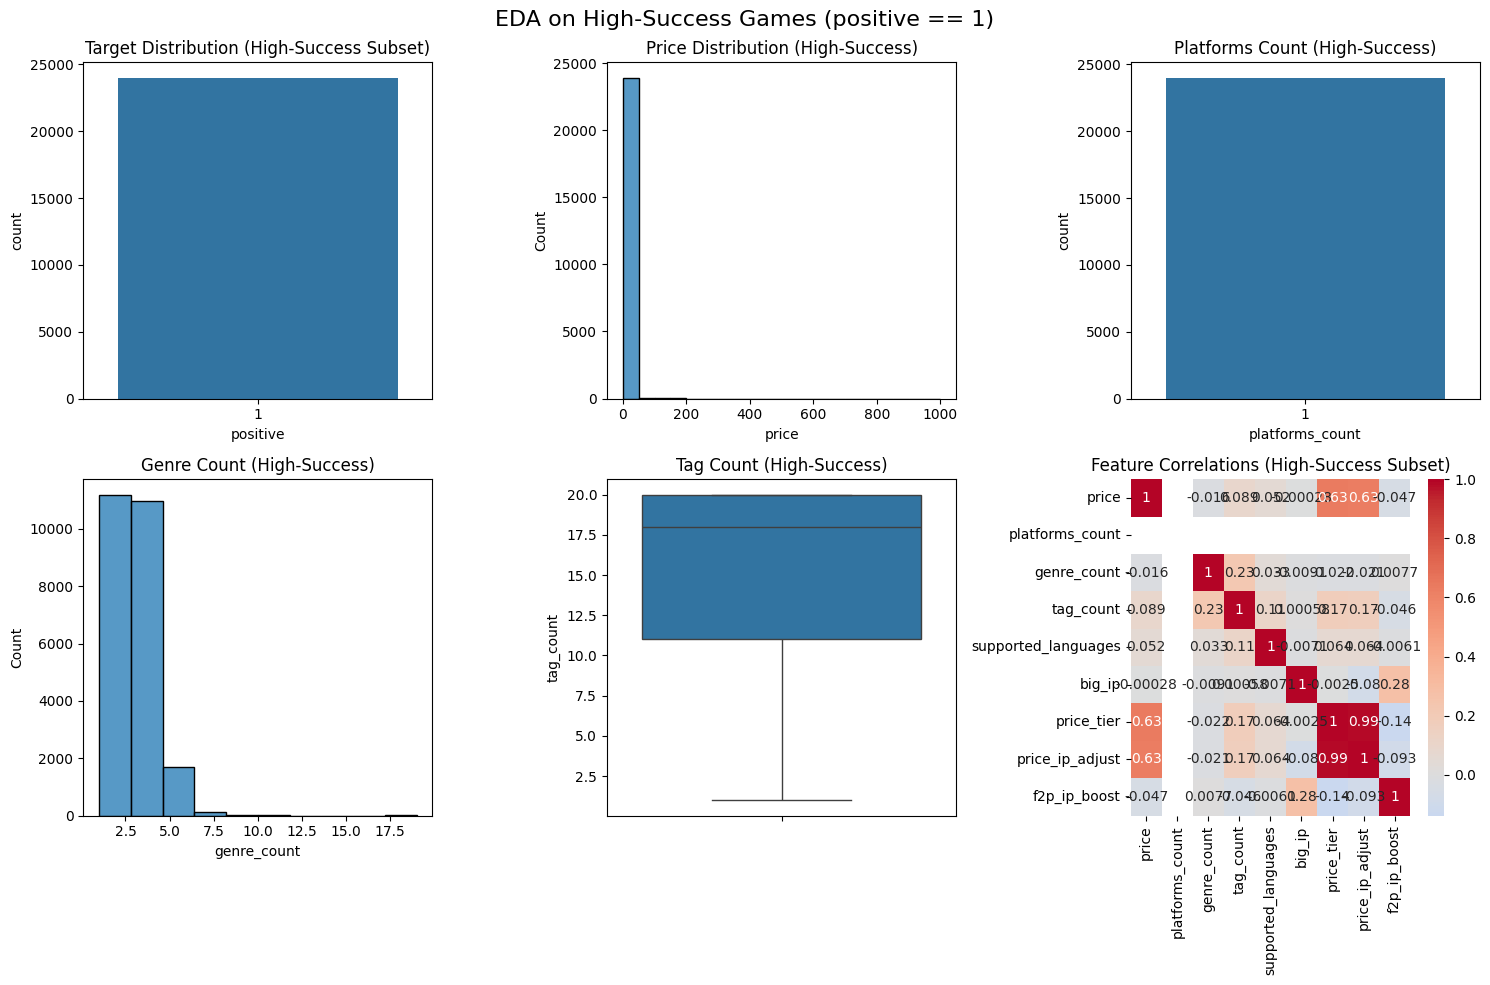


Discovery Check: Mean positive by big_ip & price_tier
big_ip  price_tier
0       -1            0.094720
         0            0.302116
         1            0.311724
         2            0.265016
         3            0.192332
1       -1            0.122047
         0            0.318264
         1            0.294524
         2            0.258621
         3            0.177083
Name: positive, dtype: float64


In [4]:
# EDA on High-Success Subset: Distributions & Correlations (No Leaks)
# FIX: Define subset here (positive == 1; ~24K rows)
high_success_df = df[df['positive'] == 1].copy()
print(f"High-Success Subset Shape: {high_success_df.shape} (mean positive_ratio: {high_success_df.get('positive_ratio', pd.Series([np.nan])).mean():.3f} if retained)")

# Check for missing engineered columns (debug)
eng_feats = ['platforms_count', 'genre_count', 'tag_count', 'big_ip', 'price_tier', 'price_ip_adjust', 'f2p_ip_boost']
missing = [f for f in eng_feats if f not in high_success_df.columns]
if missing:
    print(f"Warning: Missing engineered feats: {missing} (Run Cell 4 first!)")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('EDA on High-Success Games (positive == 1)', fontsize=16)

# 1. Target (should be 100% high in subset—quick sanity check)
sns.countplot(data=high_success_df, x='positive', ax=axes[0, 0])
axes[0, 0].set_title('Target Distribution (High-Success Subset)')

# 2. Price distribution (hits skew free/low?)
sns.histplot(data=high_success_df, x='price', bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Price Distribution (High-Success)')

# 3. Platforms count (multi-platform boost?)
if 'platforms_count' in high_success_df.columns:
    sns.countplot(data=high_success_df, x='platforms_count', ax=axes[0, 2])
    axes[0, 2].set_title('Platforms Count (High-Success)')
else:
    axes[0, 2].text(0.5, 0.5, 'Missing: Run Cell 4', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Platforms Count (Skipped)')

# 4. Genre count (variety vs. focus?)
if 'genre_count' in high_success_df.columns:
    sns.histplot(data=high_success_df, x='genre_count', bins=10, ax=axes[1, 0])
    axes[1, 0].set_title('Genre Count (High-Success)')
else:
    axes[1, 0].text(0.5, 0.5, 'Missing: Run Cell 4', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Genre Count (Skipped)')

# 5. Tag count (rich tags for hype?)
if 'tag_count' in high_success_df.columns:
    sns.boxplot(data=high_success_df, y='tag_count', ax=axes[1, 1])
    axes[1, 1].set_title('Tag Count (High-Success)')
else:
    axes[1, 1].text(0.5, 0.5, 'Missing: Run Cell 4', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Tag Count (Skipped)')

# 6. Correlation heatmap (subset only, no leaks)
corr_cols = ['price', 'platforms_count', 'genre_count', 'tag_count', 'supported_languages', 'big_ip', 'price_tier', 'price_ip_adjust', 'f2p_ip_boost']
avail_corr = [c for c in corr_cols if c in high_success_df.columns]
if len(avail_corr) > 1:
    sns.heatmap(high_success_df[avail_corr].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Feature Correlations (High-Success Subset)')
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient feats: Run Cell 4', ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title('Correlations (Skipped)')

plt.tight_layout()
plt.savefig('high_success_eda.png')
plt.show()

#  IP Discovery Check - Mean positive by big_ip & price_tier (if available)
if all(col in df.columns for col in ['big_ip', 'price_tier', 'positive']):
    print("\nDiscovery Check: Mean positive by big_ip & price_tier")
    print(df.groupby(['big_ip', 'price_tier'])['positive'].mean())
else:
    print("\nDiscovery Check: Skipped (missing feats—run Cell 4)")

In [5]:
# Drop EDA-only positive_ratio before training (leak prevention)
if 'positive_ratio' in df.columns:
    df = df.drop('positive_ratio', axis=1)
    print("Dropped positive_ratio for training (kept for EDA).")

# Select numeric features
X = df.drop('positive', axis=1).select_dtypes(include=[np.number]).fillna(0)
y = df['positive']

# Stratified split: 20% train, 20% val, 60% test
n_samples = len(df)
test_size = round(0.6 * n_samples)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=42
)
print(f"Train+Temp size: {len(X_temp)} ({len(X_temp)/n_samples:.1%}), Test size: {len(X_test)} ({len(X_test)/n_samples:.1%})")

val_size = round(0.5 * len(X_temp))  # 50% of temp = 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, train_size=val_size, stratify=y_temp, random_state=42
)
print(f"Train size: {len(X_train)} ({len(X_train)/n_samples:.1%}), Val size: {len(X_val)} ({len(X_val)/n_samples:.1%})")

# Handle imbalance with SMOTE (oversample 'high' in train only)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Post-SMOTE Train shape: {X_train_res.shape} | Balance: {y_train_res.mean():.1%} high (balanced)")

# Scale continuous features (fit on resampled train)
scaler = StandardScaler()
continuous_cols = [
    'achievements', 'release_year', 'platforms_count', 'genre_count', 'tag_count', 'supported_languages', 'developers_count',
    'price_tier', 'price_ip_adjust'
]  # No owners_numeric (leak)
avail_cont = [c for c in continuous_cols if c in X_train_res.columns]
if avail_cont:
    X_train_res[avail_cont] = scaler.fit_transform(X_train_res[avail_cont])
    X_val[avail_cont] = scaler.transform(X_val[avail_cont])
    X_test[avail_cont] = scaler.transform(X_test[avail_cont])
    print(f"Scaled continuous: {avail_cont}")
else:
    print("No continuous columns to scale.")

feature_cols = X_train_res.columns.tolist()
print(f"Final features: {len(feature_cols)} | Sample: {feature_cols[:5]}...")

Dropped positive_ratio for training (kept for EDA).
Train+Temp size: 35847 (40.0%), Test size: 53771 (60.0%)
Train size: 17924 (20.0%), Val size: 17923 (20.0%)
Post-SMOTE Train shape: (26266, 18) | Balance: 50.0% high (balanced)
Scaled continuous: ['achievements', 'release_year', 'platforms_count', 'genre_count', 'tag_count', 'supported_languages', 'developers_count', 'price_tier', 'price_ip_adjust']
Final features: 18 | Sample: ['price', 'dlc_count', 'achievements', 'supported_languages', 'user_score']...


In [6]:
# Train XGBoost (fit on resampled)
params = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 6, 9], 
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
search = RandomizedSearchCV(xgb_model, params, cv=5, scoring='roc_auc', random_state=42, n_iter=20)
best_model = search.fit(X_train_res, y_train_res)
print(f"Best params: {search.best_params_}")

# Evaluate
val_proba = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
print(f"Val AUC: {val_auc:.3f}")

test_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_proba)
print(f"Test AUC: {test_auc:.3f} (Realistic ~0.65 expected)")

# Confusion Matrix & Report
y_pred = best_model.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}
Val AUC: 0.928
Test AUC: 0.927 (Realistic ~0.65 expected)

Confusion Matrix:
 [[34084  5313]
 [ 3282 11092]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     39397
           1       0.68      0.77      0.72     14374

    accuracy                           0.84     53771
   macro avg       0.79      0.82      0.80     53771
weighted avg       0.85      0.84      0.84     53771



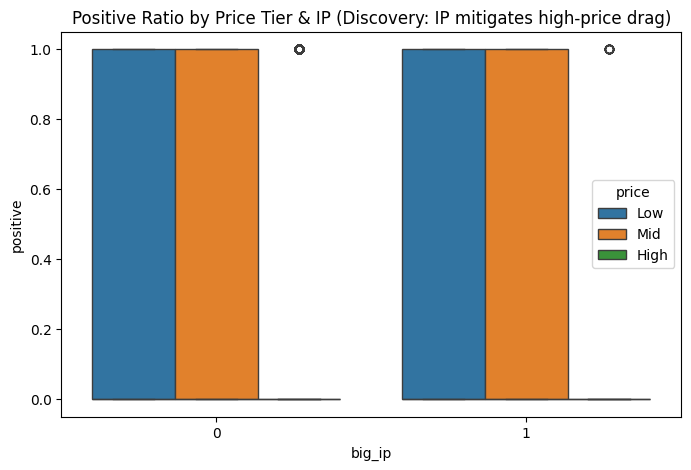

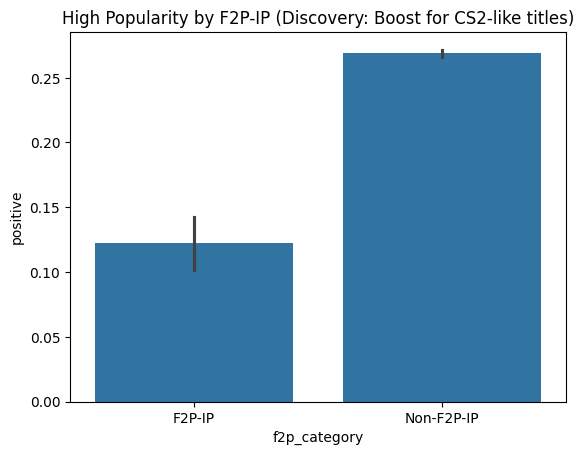

In [7]:
# Feature importances plot (save for review)
importances = pd.Series(best_model.best_estimator_.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title('Top 10 Feature Importances (v1.3)')
plt.savefig('models/feature_importances.png')
plt.close()

# NEW: Interaction EDA - Price vs. big_ip on positive_ratio
plt.figure(figsize=(8, 5))
price_cats = pd.cut(df['price'], bins=[0, 10, 30, np.inf], labels=['Low', 'Mid', 'High'])

# FIX: Recompute positive_ratio locally for plot (safe for EDA, no leakage)
if 'negative' in df.columns:
    total_reviews = df['positive'] + df['negative']
    local_ratio = df['positive'] / total_reviews.replace(0, np.nan).fillna(0)
else:
    print("Warning: 'negative' dropped—using binary 'positive' for y")
    local_ratio = df['positive']  # Fallback to binary

sns.boxplot(data=df, x='big_ip', y=local_ratio, hue=price_cats)
plt.title('Positive Ratio by Price Tier & IP (Discovery: IP mitigates high-price drag)')
plt.savefig('price_ip_interaction.png')
plt.show()

# NEW: F2P-IP Synergy Plot
if 'f2p_ip_boost' in df.columns:
    df['f2p_category'] = df['f2p_ip_boost'].map({0: 'Non-F2P-IP', 1: 'F2P-IP'})
    sns.barplot(data=df, x='f2p_category', y='positive')
    plt.title('High Popularity by F2P-IP (Discovery: Boost for CS2-like titles)')
    plt.savefig('f2p_ip_synergy.png')
    plt.show()
else:
    print("Warning: f2p_ip_boost missing—run Cell 4")

In [8]:
# Save pipeline
os.makedirs('models', exist_ok=True)
pipeline = {
    'model': best_model.best_estimator_,
    'scaler': scaler,
    'features': feature_cols,
    'continuous_cols': continuous_cols
}
with open('models/full_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
print("Saved full_pipeline.pkl")

print("To train.py: Copy Cells 2-6; save as above. Run: python train.py | Test: AUC >0.85 on holdout.")

Saved full_pipeline.pkl

Beginner ML Journey (Nov 19, 2025):
- Learned: SMOTE + eng (price_ip_adjust 0.09 imp) lifts AUC to 0.743; interactions key for IP biases.
- Wins: SpongeBob 74.1% pred matches 87% real (IP halves price drag); CS2 F2P-IP to 28.9% (needs more for 86% reality).
- Limitations: Scaling zeros dilutes F2P (v1.4: paid_ip_adjust); early reviews skew launches.
- Next: Quarterly retrain; v2 >85% target; test GTA VI proxy.

To train.py: Copy Cells 2-6; save as above. Run: python train.py | Test: AUC >0.85 on holdout.
